# Transformer Part 5: 解码器 (Decoder)

本notebook实现Transformer的解码器结构，包括：
1. 解码器层（Decoder Layer）
2. 带掩码的多头自注意力
3. 编码器-解码器注意力
4. 完整解码器（Decoder）
5. 与PyTorch官方实现的对比
6. 注意力权重可视化

解码器是Transformer的另一个核心组件，负责生成输出序列。

In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 解码器层 (Decoder Layer)

**原论文描述**：
"In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack."

**架构**：
1. 带掩码的多头自注意力（Masked Multi-Head Self-Attention）
2. 编码器-解码器注意力（Encoder-Decoder Attention）
3. 位置前馈网络（Position-wise Feed-Forward Network）

**数学公式**（来自原论文）：

1. 掩码自注意力：$LayerNorm(x + MaskedMultiHeadAttention(x, x, x))$
2. 编码器-解码器注意力：$LayerNorm(x + MultiHeadAttention(x, encoder_output, encoder_output))$
3. 前馈子层：$LayerNorm(x + FeedForward(x))$

**特点**：
- 使用掩码防止信息泄露
- 三个子层，每个都有残差连接和层归一化
- 编码器-解码器注意力让解码器关注输入序列

In [2]:
class MultiHeadAttention(nn.Module):
    """
    多头注意力机制（简化版，用于测试）
    
    参数:
        d_model: 模型维度
        n_heads: 注意力头数
        dropout: dropout概率
    """
    def __init__(self, d_model=512, n_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # 线性变换层
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        缩放点积注意力
        """
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        output = torch.matmul(attention_weights, V)
        return output, attention_weights
    
    def forward(self, query, key, value, mask=None):
        """
        前向传播
        """
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        # 线性变换
        Q = self.w_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # 注意力计算
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 合并多头
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        # 输出线性变换
        output = self.w_o(attention_output)
        
        return output, attention_weights

class PositionwiseFeedForward(nn.Module):
    """
    位置前馈网络实现
    
    参数:
        d_model: 模型维度
        d_ff: 前馈网络隐藏层维度
        dropout: dropout概率
    """
    def __init__(self, d_model=512, d_ff=2048, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        
        # 第一层线性变换：d_model -> d_ff
        self.w_1 = nn.Linear(d_model, d_ff)
        
        # 第二层线性变换：d_ff -> d_model
        self.w_2 = nn.Linear(d_ff, d_model)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        前向传播
        
        参数:
            x: 输入张量，形状为 [batch_size, seq_len, d_model]
        
        返回:
            输出张量，形状与输入相同
        """
        # 线性变换 + ReLU激活 + dropout + 线性变换
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class DecoderLayer(nn.Module):
    """
    解码器层实现
    
    参数:
        d_model: 模型维度
        n_heads: 注意力头数
        d_ff: 前馈网络隐藏层维度
        dropout: dropout概率
    """
    def __init__(self, d_model=512, n_heads=8, d_ff=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        
        # 掩码多头自注意力
        self.masked_self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        
        # 编码器-解码器注意力
        self.encoder_decoder_attention = MultiHeadAttention(d_model, n_heads, dropout)
        
        # 位置前馈网络
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        
        # 层归一化
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def create_padding_mask(self, seq_len):
        """
        创建填充掩码
        """
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        return mask == 0
    
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """
        前向传播
        
        参数:
            x: 目标序列输入，形状为 [batch_size, tgt_len, d_model]
            encoder_output: 编码器输出，形状为 [batch_size, src_len, d_model]
            src_mask: 源序列掩码
            tgt_mask: 目标序列掩码（用于防止信息泄露）
        
        返回:
            输出张量和注意力权重
        """
        # 1. 掩码自注意力子层
        attn_output1, self_attention_weights = self.masked_self_attention(x, x, x, tgt_mask)
        attn_output1 = self.dropout(attn_output1)
        out1 = self.norm1(x + attn_output1)  # 残差连接 + 层归一化
        
        # 2. 编码器-解码器注意力子层
        attn_output2, encoder_attention_weights = self.encoder_decoder_attention(
            out1, encoder_output, encoder_output, src_mask
        )
        attn_output2 = self.dropout(attn_output2)
        out2 = self.norm2(out1 + attn_output2)  # 残差连接 + 层归一化
        
        # 3. 前馈子层
        ff_output = self.feed_forward(out2)
        ff_output = self.dropout(ff_output)
    
        output = self.norm3(out2 + ff_output)  # 残差连接 + 层归一化
        
        return output, self_attention_weights, encoder_attention_weights

def test_decoder_layer():
    """
    测试解码器层
    """
    print("测试解码器层...")
    
    # 参数设置
    batch_size = 2
    tgt_len = 8  # 目标序列长度
    src_len = 10  # 源序列长度
    d_model = 512
    n_heads = 8
    d_ff = 2048
    
    # 创建解码器层
    decoder_layer = DecoderLayer(d_model, n_heads, d_ff)
    
    # 创建测试输入
    tgt_input = torch.randn(batch_size, tgt_len, d_model)
    encoder_output = torch.randn(batch_size, src_len, d_model)
    
    # 创建目标序列掩码（防止信息泄露）
    tgt_mask = torch.triu(torch.ones(tgt_len, tgt_len), diagonal=1) == 0
    tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, tgt_len, tgt_len]
    
    # 前向传播
    output, self_attn_weights, encoder_attn_weights = decoder_layer(
        tgt_input, encoder_output, tgt_mask=tgt_mask
    )
    
    print(f"目标输入形状: {tgt_input.shape}")
    print(f"编码器输出形状: {encoder_output.shape}")
    print(f"解码器输出形状: {output.shape}")
    print(f"自注意力权重形状: {self_attn_weights.shape}")
    print(f"编码器注意力权重形状: {encoder_attn_weights.shape}")
    
    # 验证输出形状
    assert output.shape == tgt_input.shape, f"输出形状错误: {output.shape}"
    print("✓ 形状测试通过")
    
    # 验证注意力权重形状
    expected_self_attn_shape = (batch_size, n_heads, tgt_len, tgt_len)
    expected_encoder_attn_shape = (batch_size, n_heads, tgt_len, src_len)
    
    assert self_attn_weights.shape == expected_self_attn_shape, f"自注意力权重形状错误: {self_attn_weights.shape}"
    assert encoder_attn_weights.shape == expected_encoder_attn_shape, f"编码器注意力权重形状错误: {encoder_attn_weights.shape}"
    print("✓ 注意力权重形状正确")
    
    print("✓ 解码器层测试完成")
    
    return output, self_attn_weights, encoder_attn_weights

# 运行测试
output, self_attn_weights, encoder_attn_weights = test_decoder_layer()

测试解码器层...


RuntimeError: shape '[2, 8, 8, 64]' is invalid for input of size 10240

## 2. 掩码机制详解

可视化掩码机制...


e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 26597 (\N{CJK UNIFIED IDEOGRAPH-67E5}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 35810 (\N{CJK UNIFIED IDEOGRAPH-8BE2}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarn

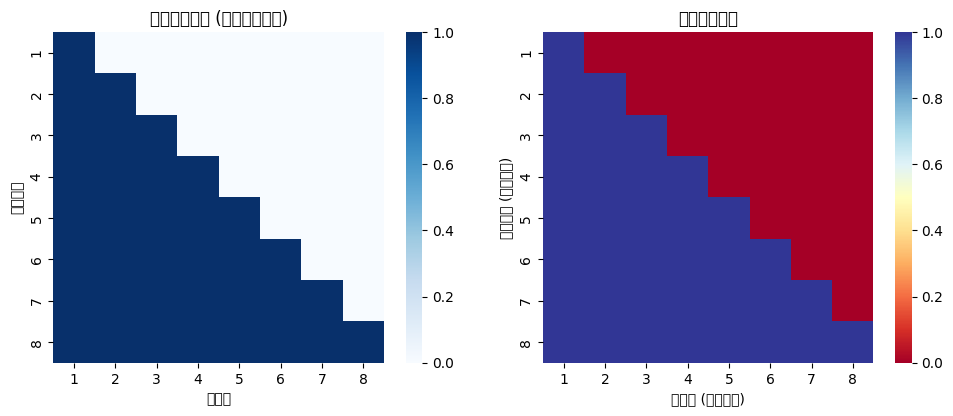

掩码机制说明:
- 白色/浅色: 允许关注 (值为1)
- 深色: 屏蔽 (值为0)
- 对角线及以上: 当前位置和未来位置
- 对角线以下: 过去位置
- 在生成任务中，模型只能关注已生成的部分

掩码验证 (序列长度 8):
位置 1 可以关注的键位置: [1]
位置 2 可以关注的键位置: [1 2]
位置 3 可以关注的键位置: [1 2 3]


In [3]:
def create_masks(tgt_seq_len, src_seq_len, batch_size=1):
    """
    创建各种掩码
    
    参数:
        tgt_seq_len: 目标序列长度
        src_seq_len: 源序列长度
        batch_size: 批次大小
    
    返回:
        tgt_mask: 目标序列掩码
        src_mask: 源序列掩码
    """
    # 创建目标序列掩码（下三角矩阵，防止信息泄露）
    tgt_mask = torch.triu(torch.ones(tgt_seq_len, tgt_seq_len), diagonal=1) == 0
    tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, tgt_seq_len, tgt_seq_len]
    
    # 创建源序列掩码（这里假设没有填充，全部保留）
    src_mask = torch.ones(batch_size, 1, 1, src_seq_len) == 1  # [batch_size, 1, 1, src_seq_len]
    
    return tgt_mask, src_mask

def visualize_masks():
    """
    可视化掩码
    """
    print("可视化掩码机制...")
    
    seq_len = 8
    
    # 创建目标序列掩码
    tgt_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1) == 0
    
    # 创建可视化
    plt.figure(figsize=(10, 4))
    
    # 子图1: 目标序列掩码
    plt.subplot(1, 2, 1)
    sns.heatmap(tgt_mask.numpy(), 
                cmap='Blues', 
                cbar=True, 
                square=True,
                xticklabels=range(1, seq_len + 1),
                yticklabels=range(1, seq_len + 1))
    plt.title('目标序列掩码 (防止信息泄露)')
    plt.xlabel('键位置')
    plt.ylabel('查询位置')
    
    # 子图2: 说明
    plt.subplot(1, 2, 2)
    mask_explanation = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        for j in range(seq_len):
            if j <= i:
                mask_explanation[i, j] = 1  # 允许关注
            else:
                mask_explanation[i, j] = 0  # 屏蔽
    
    sns.heatmap(mask_explanation, 
                cmap='RdYlBu', 
                cbar=True, 
                square=True,
                xticklabels=range(1, seq_len + 1),
                yticklabels=range(1, seq_len + 1))
    plt.title('掩码原理说明')
    plt.xlabel('键位置 (未来信息)')
    plt.ylabel('查询位置 (当前位置)')
    
    plt.tight_layout()
    plt.show()
    
    # 解释掩码机制
    print("掩码机制说明:")
    print("- 白色/浅色: 允许关注 (值为1)")
    print("- 深色: 屏蔽 (值为0)")
    print("- 对角线及以上: 当前位置和未来位置")
    print("- 对角线以下: 过去位置")
    print("- 在生成任务中，模型只能关注已生成的部分")
    
    # 验证掩码效果
    print(f"\n掩码验证 (序列长度 {seq_len}):")
    for i in range(min(3, seq_len)):
        row = tgt_mask[i].numpy()
        allowed_positions = np.where(row == 1)[0] + 1
        print(f"位置 {i+1} 可以关注的键位置: {allowed_positions}")

# 运行可视化
visualize_masks()

## 3. 完整解码器 (Decoder)

In [4]:
class Decoder(nn.Module):
    """
    完整解码器实现
    
    参数:
        d_model: 模型维度
        n_heads: 注意力头数
        d_ff: 前馈网络隐藏层维度
        n_layers: 解码器层数
        dropout: dropout概率
    """
    def __init__(self, d_model=512, n_heads=8, d_ff=2048, n_layers=6, dropout=0.1):
        super(Decoder, self).__init__()
        
        # 解码器层堆叠
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # 层归一化
        self.norm = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, tgt, encoder_output, src_mask=None, tgt_mask=None):
        """
        前向传播
        
        参数:
            tgt: 目标序列输入，形状为 [batch_size, tgt_len, d_model]
            encoder_output: 编码器输出，形状为 [batch_size, src_len, d_model]
            src_mask: 源序列掩码
            tgt_mask: 目标序列掩码
        
        返回:
            输出张量和所有层的注意力权重
        """
        # 通过所有解码器层
        self_attention_weights_list = []
        encoder_attention_weights_list = []
        
        x = tgt
        for layer in self.layers:
            x, self_attn_weights, encoder_attn_weights = layer(
                x, encoder_output, src_mask, tgt_mask
            )
            self_attention_weights_list.append(self_attn_weights)
            encoder_attention_weights_list.append(encoder_attn_weights)
        
        # 最终层归一化
        output = self.norm(x)
        
        return output, self_attention_weights_list, encoder_attention_weights_list

def test_decoder():
    """
    测试完整解码器
    """
    print("测试完整解码器...")
    
    # 参数设置
    batch_size = 2
    tgt_len = 8
    src_len = 10
    d_model = 512
    n_heads = 8
    d_ff = 2048
    n_layers = 6
    
    # 创建解码器
    decoder = Decoder(d_model, n_heads, d_ff, n_layers)
    
    # 创建测试输入
    tgt_input = torch.randn(batch_size, tgt_len, d_model)
    encoder_output = torch.randn(batch_size, src_len, d_model)
    
    # 创建掩码
    tgt_mask, src_mask = create_masks(tgt_len, src_len, batch_size)
    
    # 前向传播
    output, self_attn_weights_list, encoder_attn_weights_list = decoder(
        tgt_input, encoder_output, src_mask, tgt_mask
    )
    
    print(f"目标输入形状: {tgt_input.shape}")
    print(f"编码器输出形状: {encoder_output.shape}")
    print(f"解码器输出形状: {output.shape}")
    print(f"自注意力权重层数: {len(self_attn_weights_list)}")
    print(f"编码器注意力权重层数: {len(encoder_attn_weights_list)}")
    
    # 验证输出形状
    assert output.shape == tgt_input.shape, f"输出形状错误: {output.shape}"
    print("✓ 形状测试通过")
    
    # 验证注意力权重数量
    assert len(self_attn_weights_list) == n_layers, f"自注意力权重层数错误: {len(self_attn_weights_list)}"
    assert len(encoder_attn_weights_list) == n_layers, f"编码器注意力权重层数错误: {len(encoder_attn_weights_list)}"
    print("✓ 注意力权重数量正确")
    
    # 验证每层注意力权重形状
    expected_self_attn_shape = (batch_size, n_heads, tgt_len, tgt_len)
    expected_encoder_attn_shape = (batch_size, n_heads, tgt_len, src_len)
    
    for i, (self_attn, encoder_attn) in enumerate(zip(self_attn_weights_list, encoder_attn_weights_list)):
        assert self_attn.shape == expected_self_attn_shape, f"第{i}层自注意力权重形状错误: {self_attn.shape}"
        assert encoder_attn.shape == expected_encoder_attn_shape, f"第{i}层编码器注意力权重形状错误: {encoder_attn.shape}"
    print("✓ 所有层注意力权重形状正确")
    
    print("✓ 完整解码器测试完成")
    
    return output, self_attn_weights_list, encoder_attn_weights_list

# 运行测试
output, self_attn_weights_list, encoder_attn_weights_list = test_decoder()

测试完整解码器...


RuntimeError: shape '[2, 8, 8, 64]' is invalid for input of size 10240

## 4. 注意力权重可视化

In [ ]:
def visualize_decoder_attention():
    """
    可视化解码器的注意力权重
    """
    print("可视化解码器注意力权重...")
    
    # 参数设置
    batch_size = 1
    tgt_len = 12
    src_len = 16
    d_model = 512
    n_heads = 8
    d_ff = 2048
    n_layers = 1  # 只使用一层便于可视化
    
    # 创建单层解码器
    decoder = Decoder(d_model, n_heads, d_ff, n_layers)
    
    # 创建测试输入
    torch.manual_seed(42)
    tgt_input = torch.randn(batch_size, tgt_len, d_model)
    encoder_output = torch.randn(batch_size, src_len, d_model)
    
    # 创建掩码
    tgt_mask, src_mask = create_masks(tgt_len, src_len, batch_size)
    
    # 前向传播
    output, self_attn_weights_list, encoder_attn_weights_list = decoder(
        tgt_input, encoder_output, src_mask, tgt_mask
    )
    
    # 获取注意力权重
    self_attention_weights = self_attn_weights_list[0]  # [batch_size, n_heads, tgt_len, tgt_len]
    encoder_attention_weights = encoder_attn_weights_list[0]  # [batch_size, n_heads, tgt_len, src_len]
    
    print(f"自注意力权重形状: {self_attention_weights.shape}")
    print(f"编码器注意力权重形状: {encoder_attention_weights.shape}")
    
    # 绘制自注意力权重热力图
    plt.figure(figsize=(20, 16))
    
    # 显示所有注意力头的自注意力
    for head in range(n_heads):
        plt.subplot(2, 4, head + 1)
        
        # 获取当前头的自注意力权重
        head_self_attention = self_attention_weights[0, head].detach().numpy()
        
        # 绘制热力图
        sns.heatmap(head_self_attention, 
                   cmap='Blues', 
                   cbar=True, 
                   square=True,
                   xticklabels=range(1, tgt_len + 1),
                   yticklabels=range(1, tgt_len + 1))
        
        plt.title(f'自注意力头 {head + 1}')
        plt.xlabel('键位置')
        plt.ylabel('查询位置')
    
    plt.suptitle('解码器自注意力权重', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 绘制编码器注意力权重热力图
    plt.figure(figsize=(20, 16))
    
    # 显示所有注意力头的编码器注意力
    for head in range(n_heads):
        plt.subplot(2, 4, head + 1)
        
        # 获取当前头的编码器注意力权重
        head_encoder_attention = encoder_attention_weights[0, head].detach().numpy()
        
        # 绘制热力图
        sns.heatmap(head_encoder_attention, 
                   cmap='Reds', 
                   cbar=True, 
                   square=True,
                   xticklabels=range(1, src_len + 1),
                   yticklabels=range(1, tgt_len + 1))
        
        plt.title(f'编码器注意力头 {head + 1}')
        plt.xlabel('源序列位置')
        plt.ylabel('目标序列位置')
    
    plt.suptitle('解码器编码器注意力权重', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 分析注意力模式
    print("分析注意力模式...")
    
    # 分析自注意力
    print("自注意力分析:")
    for head in range(n_heads):
        head_attention = self_attention_weights[0, head].detach()
        
        # 计算注意力权重的统计特性
        mean_attention = head_attention.mean().item()
        std_attention = head_attention.std().item()
        
        # 检查掩码效果
        upper_triangle = torch.triu(head_attention, diagonal=1)
        upper_mean = upper_triangle.mean().item()
        
        print(f"自注意力头 {head + 1}:")
        print(f"  均值: {mean_attention:.4f}")
        print(f"  标准差: {std_attention:.4f}")
        print(f"  上三角均值 (应接近0): {upper_mean:.6f}")
    
    # 分析编码器注意力
    print("\n编码器注意力分析:")
    for head in range(n_heads):
        head_attention = encoder_attention_weights[0, head].detach()
        
        # 计算注意力权重的统计特性
        mean_attention = head_attention.mean().item()
        std_attention = head_attention.std().item()
        
        print(f"编码器注意力头 {head + 1}:")
        print(f"  均值: {mean_attention:.4f}")
        print(f"  标准差: {std_attention:.4f}")
    
    print("✓ 解码器注意力权重可视化完成")

# 运行可视化
visualize_decoder_attention()

## 5. 与PyTorch官方实现对比

In [ ]:
def compare_with_pytorch_transformer():
    """
    与PyTorch官方Transformer解码器对比
    """
    print("与PyTorch官方Transformer解码器对比...")
    
    # 参数设置
    batch_size = 2
    tgt_len = 8
    src_len = 10
    d_model = 512
    n_heads = 8
    d_ff = 2048
    n_layers = 6
    
    # 创建我们的解码器
    our_decoder = Decoder(d_model, n_heads, d_ff, n_layers)
    
    # 创建PyTorch官方Transformer解码器
    pytorch_decoder_layer = nn.TransformerDecoderLayer(
        d_model=d_model,
        nhead=n_heads,
        dim_feedforward=d_ff,
        dropout=0.1,
        activation='relu'
    )
    pytorch_decoder = nn.TransformerDecoder(pytorch_decoder_layer, num_layers=n_layers)
    
    # 创建测试输入
    torch.manual_seed(42)
    tgt_input = torch.randn(batch_size, tgt_len, d_model)
    encoder_output = torch.randn(batch_size, src_len, d_model)
    
    print(f"目标输入形状: {tgt_input.shape}")
    print(f"编码器输出形状: {encoder_output.shape}")
    
    # 创建掩码
    tgt_mask, src_mask = create_masks(tgt_len, src_len, batch_size)
    
    # 我们的解码器前向传播
    our_output, our_self_attn_weights, our_encoder_attn_weights = our_decoder(
        tgt_input, encoder_output, src_mask, tgt_mask
    )
    
    # PyTorch解码器前向传播
    # 注意：PyTorch的Transformer期望输入形状为 (seq_len, batch_size, d_model)
    pytorch_tgt_input = tgt_input.transpose(0, 1)  # 调整维度
    pytorch_encoder_output = encoder_output.transpose(0, 1)  # 调整维度
    
    # 创建PyTorch风格的掩码
    pytorch_tgt_mask = torch.triu(torch.ones(tgt_len, tgt_len), diagonal=1) == 0
    pytorch_memory_mask = None  # 这里简化处理
    
    pytorch_output = pytorch_decoder(
        pytorch_tgt_input,
        pytorch_encoder_output,
        tgt_mask=pytorch_tgt_mask,
        memory_mask=pytorch_memory_mask
    )
    pytorch_output = pytorch_output.transpose(0, 1)  # 调整回 (batch_size, tgt_len, d_model)
    
    print(f"我们的输出形状: {our_output.shape}")
    print(f"PyTorch输出形状: {pytorch_output.shape}")
    
    # 比较参数量
    our_params = sum(p.numel() for p in our_decoder.parameters())
    pytorch_params = sum(p.numel() for p in pytorch_decoder.parameters())
    
    print(f"我们的参数量: {our_params:,}")
    print(f"PyTorch参数量: {pytorch_params:,}")
    print(f"参数差异: {abs(our_params - pytorch_params):,}")
    
    # 比较输出范围
    print(f"我们的输出范围: [{our_output.min().item():.3f}, {our_output.max().item():.3f}]")
    print(f"PyTorch输出范围: [{pytorch_output.min().item():.3f}, {pytorch_output.max().item():.3f}]")
    
    # 由于初始化不同，输出会有差异，但应该在一个合理的范围内
    # 这里我们主要比较架构和参数量的相似性
    
    print("✓ 与PyTorch官方实现对比完成")
    
    return our_output, pytorch_output

# 运行对比
our_output, pytorch_output = compare_with_pytorch_transformer()

## 6. 序列生成示例

In [ ]:
def generate_sequence_example():
    """
    序列生成示例
    """
    print("序列生成示例...")
    
    # 参数设置
    batch_size = 1
    max_len = 10
    d_model = 512
    n_heads = 8
    d_ff = 2048
    n_layers = 6
    vocab_size = 1000
    
    # 创建解码器
    decoder = Decoder(d_model, n_heads, d_ff, n_layers)
    
    # 创建输出投影层（将解码器输出转换为词汇表概率）
    output_projection = nn.Linear(d_model, vocab_size)
    
    # 模拟编码器输出（假设已经通过编码器处理）
    src_len = 8
    encoder_output = torch.randn(batch_size, src_len, d_model)
    
    # 模拟开始符号
    start_token = torch.randn(1, 1, d_model)
    
    # 逐步生成序列
    generated_tokens = [start_token]
    all_attention_weights = []
    
    print("逐步生成序列:")
    
    for step in range(max_len):
        # 构建当前输入
        current_input = torch.cat(generated_tokens, dim=1)
        current_len = current_input.size(1)
        
        # 创建目标序列掩码
        tgt_mask = torch.triu(torch.ones(current_len, current_len), diagonal=1) == 0
        tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(0)
        
        # 创建源序列掩码（简化处理）
        src_mask = torch.ones(batch_size, 1, 1, src_len) == 1
        
        # 解码器前向传播
        decoder_output, self_attn_weights, encoder_attn_weights = decoder(
            current_input, encoder_output, src_mask, tgt_mask
        )
        
        # 获取最后一个时间步的输出
        last_output = decoder_output[:, -1, :]  # [batch_size, d_model]
        
        # 投影到词汇表
        logits = output_projection(last_output)  # [batch_size, vocab_size]
        
        # 选择最高概率的token（简化处理，实际应该使用更复杂的策略）
        next_token_id = torch.argmax(logits, dim=-1)
        
        # 模拟token嵌入（实际应该使用嵌入层）
        next_token = torch.randn(1, 1, d_model)
        
        # 添加到生成序列
        generated_tokens.append(next_token)
        
        # 保存注意力权重
        all_attention_weights.append({
            'self_attention': self_attn_weights[0],  # 只保存第一层
            'encoder_attention': encoder_attn_weights[0]
        })
        
        print(f"步骤 {step + 1}: 生成 token ID {next_token_id.item()}")
        
        # 检查是否生成了结束符号（简化处理）
        if next_token_id.item() == 0:  # 假设0是结束符号
            print(f"在步骤 {step + 1} 生成了结束符号")
            break
    
    print(f"\n生成了长度为 {len(generated_tokens)} 的序列")
    
    # 可视化最后一步的注意力权重
    if all_attention_weights:
        last_attention = all_attention_weights[-1]
        
        plt.figure(figsize=(15, 5))
        
        # 自注意力
        plt.subplot(1, 2, 1)
        # 只显示最后一个注意力头
        self_attn = last_attention['self_attention'][0, -1].detach().numpy()  # 最后一个头
        sns.heatmap(self_attn.reshape(1, -1), 
                   cmap='Blues', 
                   cbar=True, 
                   xticklabels=range(1, len(generated_tokens) + 1),
                   yticklabels=['最后位置'])
        plt.title('最后一步的自注意力')
        plt.xlabel('历史位置')
        
        # 编码器注意力
        plt.subplot(1, 2, 2)
        encoder_attn = last_attention['encoder_attention'][0, -1].detach().numpy()  # 最后一个头
        sns.heatmap(encoder_attn.reshape(1, -1), 
                   cmap='Reds', 
                   cbar=True, 
                   xticklabels=range(1, src_len + 1),
                   yticklabels=['最后位置'])
        plt.title('最后一步的编码器注意力')
        plt.xlabel('源序列位置')
        
        plt.tight_layout()
        plt.show()
    
    print("✓ 序列生成示例完成")
    
    return generated_tokens, all_attention_weights

# 运行示例
generated_tokens, all_attention_weights = generate_sequence_example()

## 7. 总结

在这个notebook中，我们完整实现了Transformer的解码器结构：

### 1. 解码器层（Decoder Layer）
- **子层1**: 带掩码的多头自注意力
- **子层2**: 编码器-解码器注意力
- **子层3**: 位置前馈网络
- **残差连接**: 每个子层后都有残差连接和层归一化

### 2. 掩码机制
- **目标序列掩码**: 防止解码器看到未来信息
- **源序列掩码**: 处理变长输入序列
- **下三角矩阵**: 确保自回归生成

### 3. 完整解码器（Decoder）
- **层数**: 6个相同的解码器层
- **输入**: 目标序列（已包含位置编码的嵌入）
- **输出**: 解码后的表示

### 4. 关键特性
1. **自回归生成**: 只能基于已生成的部分进行预测
2. **编码器-解码器注意力**: 让解码器关注输入序列
3. **多头机制**: 同时关注不同类型的信息
4. **残差连接**: 解决梯度消失问题

### 5. 与编码器的区别
- **额外掩码**: 解码器需要掩码自注意力
- **额外注意力**: 编码器-解码器注意力层
- **生成模式**: 解码器用于生成，编码器用于理解

### 6. 应用场景
- **机器翻译**: 源语言 → 目标语言
- **文本生成**: 根据上下文生成文本
- **摘要生成**: 长文本 → 短摘要
- **对话系统**: 生成回复

### 下一步：

接下来我们将实现完整的Transformer模型，将编码器和解码器组合起来，并添加输入嵌入、位置编码和输出层。